Training started...
Epoch 1/10 | Train Acc: 50.48% | Val Acc: 49.00% | Test Acc: 48.44%
Epoch 2/10 | Train Acc: 62.92% | Val Acc: 57.69% | Test Acc: 59.31%
Epoch 3/10 | Train Acc: 72.33% | Val Acc: 64.81% | Test Acc: 67.25%
Epoch 4/10 | Train Acc: 79.54% | Val Acc: 70.88% | Test Acc: 74.88%
Epoch 5/10 | Train Acc: 80.29% | Val Acc: 66.62% | Test Acc: 70.31%
Epoch 6/10 | Train Acc: 85.79% | Val Acc: 75.81% | Test Acc: 75.50%
Epoch 7/10 | Train Acc: 87.27% | Val Acc: 74.06% | Test Acc: 74.62%
Epoch 8/10 | Train Acc: 87.35% | Val Acc: 74.50% | Test Acc: 75.19%
Epoch 9/10 | Train Acc: 89.12% | Val Acc: 74.75% | Test Acc: 74.19%
Epoch 10/10 | Train Acc: 89.31% | Val Acc: 74.12% | Test Acc: 73.44%

Training Complete!
+-------+--------------------+-------------------------+-------------------+---------------+
| Epoch | Train Accuracy (%) | Validation Accuracy (%) | Test Accuracy (%) | Learning Rate |
+-------+--------------------+-------------------------+-------------------+---------------+


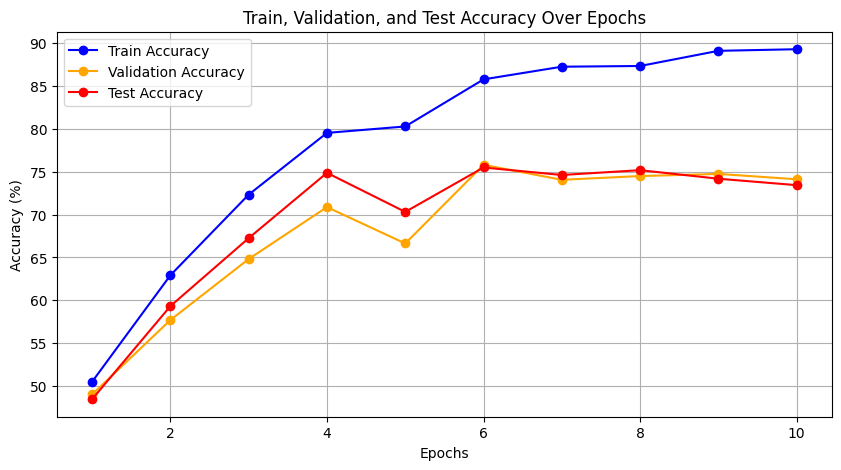

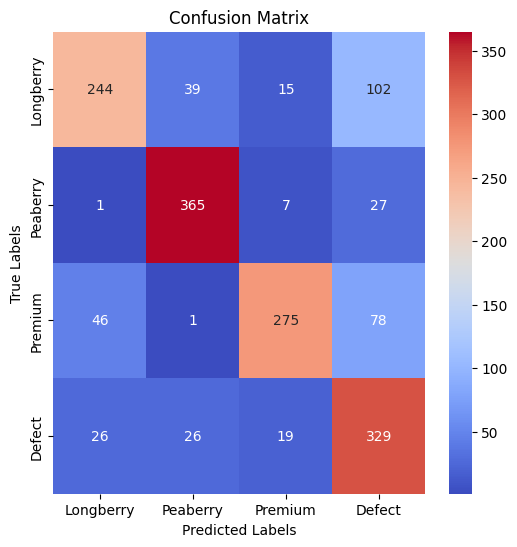

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, confusion_matrix
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from colored import fg, attr
import numpy as np

# Set device (no error message if CUDA is unavailable)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data with Optimized Transformations
def get_dataloader(batch_size=16):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  
        transforms.RandomHorizontalFlip(),  
        transforms.RandomRotation(10),  
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    train_dataset = datasets.ImageFolder(root='C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\train', transform=transform)
    test_dataset = datasets.ImageFolder(root='C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\test', transform=transform)
    val_dataset = datasets.ImageFolder(root='C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\val', transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader

train_loader, test_loader, val_loader = get_dataloader()

# Define Semantic CNN Model
class SemanticCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SemanticCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# Initialize the student model
student_model = SemanticCNN().to(device)

# Apply Sparsity
def apply_sparsity(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            prune.l1_unstructured(module, name="weight", amount=amount)
    return model

apply_sparsity(student_model)

# Compute Accuracy & F1 Score
def compute_metrics(model, dataloader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, f1, all_preds, all_labels

# Train Model with Optimizations
def train_model(student, train_loader, val_loader, test_loader, epochs=10, lr=0.001):
    optimizer = optim.Adam(student.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  
    loss_fn = nn.CrossEntropyLoss()

    train_accs, val_accs, test_accs = [], [], []
    
    print(f"{fg('green')}Training started...{attr('reset')}")

    for epoch in range(epochs):
        total_loss, correct_train, total_train = 0, 0, 0

        student.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            student_outputs = student(images)
            loss = loss_fn(student_outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()

        train_acc, _, _, _ = compute_metrics(student, train_loader)
        val_acc, _, _, _ = compute_metrics(student, val_loader)
        test_acc, _, _, _ = compute_metrics(student, test_loader)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {fg('blue')}{train_acc:.2f}%{attr('reset')} | Val Acc: {fg('yellow')}{val_acc:.2f}%{attr('reset')} | Test Acc: {fg('red')}{test_acc:.2f}%{attr('reset')}")

    print(f"\n{fg('green')}Training Complete!{attr('reset')}")

    # Print results in table
    table = PrettyTable(["Epoch", "Train Accuracy (%)", "Validation Accuracy (%)", "Test Accuracy (%)", "Learning Rate"])
    for i in range(epochs):
        table.add_row([i+1, train_accs[i], val_accs[i], test_accs[i], lr])
    print(table)

    # Visualization
    epochs_range = range(1, epochs + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_accs, label='Train Accuracy', marker='o', color='blue')
    plt.plot(epochs_range, val_accs, label='Validation Accuracy', marker='o', color='orange')
    plt.plot(epochs_range, test_accs, label='Test Accuracy', marker='o', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train, Validation, and Test Accuracy Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix
    _, _, all_preds, all_labels = compute_metrics(student, test_loader)
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Longberry", "Peaberry", "Premium", "Defect"], yticklabels=["Longberry", "Peaberry", "Premium", "Defect"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

train_model(student_model, train_loader, val_loader, test_loader)
